In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_data= pd.read_csv("/content/drive/MyDrive/YL/metin_madenciligi_proje/preprocessed_european_comments.csv")

In [4]:
train_data.head()

,Unnamed: 0,body,Subjectivity,Polarity,Analysis
0,0,"woman claims said insults, bystanders didnt. t...",0.843750,-0.322917,Negative
1,1,turkey doesn't know balkans.,0.000000,0.000000,Neutral
2,2,lot talk turkey,0.000000,0.000000,Neutral
3,3,don't like ruling party turkey. it's turkish p...,0.000000,0.000000,Neutral
4,4,create confusion absolute numbers. ~0.01 popul...,0.423384,-0.020833,Negative


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Positive    34026
Negative    21331
Neutral     16463
Name: Analysis, dtype: int64
Total comments:  71820


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :3263


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

#x_train = tokenizer.texts_to_matrix(X_train.values.astype(str))
#x_test  = tokenizer.texts_to_matrix(X_test.values.astype(str))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [13]:
print(train_labels[:10])

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [14]:
# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                   embeddings_regularizer = regularizers.l2(0.0005))) 

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc')])

In [15]:
# Training model

callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Fit the model using the train and test datasets.
history = model.fit(x_train,
                    train_labels,
                    epochs= 10,
                    callbacks=callbacks,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
2020/2020 [==============================] - 17s 8ms/step - loss: 0.7341 - accuracy: 0.7281 - auc: 0.8966 - val_loss: 0.5822 - val_accuracy: 0.8484 - val_auc: 0.9558
Epoch 2/10
2020/2020 [==============================] - 15s 7ms/step - loss: 0.5217 - accuracy: 0.8820 - auc: 0.9698 - val_loss: 0.5536 - val_accuracy: 0.8719 - val_auc: 0.9666
Epoch 3/10
2020/2020 [==============================] - 15s 7ms/step - loss: 0.4759 - accuracy: 0.9136 - auc: 0.9817 - val_loss: 0.5919 - val_accuracy: 0.8771 - val_auc: 0.9664
Epoch 4/10
2020/2020 [==============================] - 15s 7ms/step - loss: 0.4363 - accuracy: 0.9347 - auc: 0.9882 - val_loss: 0.6571 - val_accuracy: 0.8691 - val_auc: 0.9597
Epoch 5/10
2020/2020 [==============================] - 15s 7ms/step - loss: 0.4132 - accuracy: 0.9462 - auc: 0.9912 - val_loss: 0.6877 - val_accuracy: 0.8687 - val_auc: 0.9582


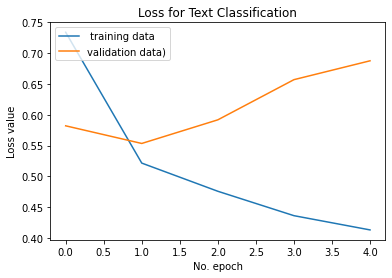

In [16]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

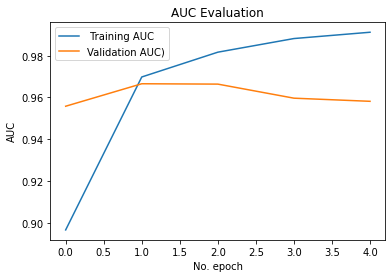

In [17]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [18]:
X_test

58787    old news based kktc’s president said. afaik (o...
16737    words "turkey doesn't want follow unclos inven...
27353       thought turk guys ok posts turkey /r/europe :d
62209    true. tides shift comes time slaughtered disag...
40789    thanks do, mate. mission seek help reddit prev...
                               ...                        
24478    didn't send them, let go. huge difference lett...
30753    [so, addresses "what simply refuse import will...
9977     turkey arrested right? highest number journali...
7303     doesn't story baltics analogous cyprus. popula...
32862    isn't co2 tax, alternative bar lpg. turkey hug...
Name: body, Length: 7182, dtype: object

In [19]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples


array([0, 2, 2, ..., 2, 2, 2])

In [21]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [22]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       0.88      0.89      0.88      3426
    Negative       0.81      0.81      0.81      2097
     Neutral       0.92      0.90      0.91      1659

    accuracy                           0.87      7182
   macro avg       0.87      0.87      0.87      7182
weighted avg       0.87      0.87      0.87      7182

